In [1]:
# This code cell imports stuff, etc.

import numpy as np
import matplotlib.pyplot as plt
from time import time as tm
import seaborn as sns

# Import local functions and params
from utils import *
from SpikingNetworkModels import EIFNetworkSim
#from DefaultParams import *




Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import numpy as np

# Time duration and step size of sim in ms
T=20000
dt=.1
time=np.arange(0,T,dt)
Nt=len(time)
Tburn=2000
Nburn=int(Tburn/dt)

# Number of E and I neurons in network
Ne = 4000
Ni = 1000
Ns=[Ne,Ni]
N = Ne+Ni


# Connection probabilities and weights between
# E and I neurons
P = np.array([[.1,.1],[.1,.1]])
Jm = np.array([[25.0,-150.0],[112.5,-250.0]])/np.sqrt(N)

# Synaptic time constants in ms
tau=np.array([8.0,4.0])


# Neuron parameters
NeuronParams = dict()
NeuronParams['Cm']=1.0
NeuronParams['gL']=1/15.0
NeuronParams['EL']=-72.0
NeuronParams['Vth']=0.0
NeuronParams['Vre']=-75.0
NeuronParams['Vlb']=-100.0
NeuronParams['DeltaT']=1.0
NeuronParams['VT']=-55.0


# Mean-field variables
Q=np.array([[Ne,Ni],[Ne,Ni]])/N
Wmf = Jm*P*Q*np.sqrt(N)
Xmf = np.array([.036,.027])

# Baseline external input to each neuron
X0 = Xmf*np.sqrt(N)

# Compute balanced rates for E and I neurons.
# This gives a rough approx to the actual rates
# if the network is approximately balanced.
rBal = -np.linalg.inv(Wmf)@Xmf

# Stimulus params
StimDim = 10
taustim = 30.0
sigmastim = X0.mean()/10.0

print('rBal = ',1000*rBal[0],1000*rBal[1],'Hz')

# Params for multi-trial sims
numtrials=2
dtRate=250


rBal =  5.823529411764702 15.882352941176466 Hz


In [3]:

#Jx=np.zeros(N,StimDim)
p0=.1
Jx=sigmastim*(0.2*np.random.rand(N,StimDim)+.2)
Jx[Ne:,:]=0

alpha=0.5
Pe1 = Jx[:Ne,:]@Jx[:Ne,:].T
Pe1 = Pe1*(p0/Pe1.mean())

Pee=2*alpha*Pe1+(1-alpha)*p0

# P=np.zeros((N,N))+0.1
# P[:Ne,:Ne]=Pee


# # Get connectivity matrix
# J=GetBlockErdosRenyi(Ns,Jm,P,Ns)
J=np.zeros((N,N))
J[:Ne,:Ne]=Jm[0,0]*(np.random.binomial(1, Pee, size=(Ne, Ne)))
J[Ne:,:Ne]=Jm[1,0]*(np.random.binomial(1, 0.1, size=(Ni, Ne)))
J[:Ne,Ne:]=Jm[0,1]*(np.random.binomial(1, 0.1, size=(Ne, Ni)))
J[Ne:,Ne:]=Jm[1,1]*(np.random.binomial(1, 0.1, size=(Ni, Ni)))



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
# This code cell creates connectivity, stimulus, and runs sims

import warnings

    

# External input on top of baseline
X=np.zeros((StimDim,Nt))
for j in range(StimDim):
  X[j,:]=MakeSmoothGaussianProcess(taustim,Nt,dt)



maxns=int(.05*Ne*Nt)+1
Ierecord=[0,1,2]
t0=tm()
RateTime=np.arange(0,T,dtRate)
re = np.zeros((numtrials,Ne,len(RateTime)))
ri = np.zeros((numtrials,Ni,len(RateTime)))
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    for iii in range(numtrials):        
        se,si,VeRec = EIFNetworkSim(J,Jx,X,X0,Ne,NeuronParams,tau,Nt,dt,maxns,Ierecord)
        se=se[:,se[0,:]>=0]
        si=si[:,si[0,:]>=0]
        re[iii,:,:] = GetSpikeCounts(se,dtRate,Ne,T)/dtRate
        ri[iii,:,:] = GetSpikeCounts(si,dtRate,Ni,T)/dtRate
        print('Sim for trial',iii,'of',numtrials,'complete after',tm()-t0,'s')        
tSim=tm()-t0
print('Time for all sims:',tSim,'s')


MeanERates=re.mean()
MeanIRates=ri.mean()

print('rSim =',1000*MeanERates,1000*MeanIRates,'Hz')


Sim for trial 0 of 2 complete after 42.54499888420105 s
Sim for trial 1 of 2 complete after 84.89870810508728 s
Time for all sims: 84.89889812469482 s
rSim = 7.449700000000002 18.4467 Hz


2032 of 4000 E neurons made the cut.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
2
Mean EE corr: 0.05076037533765009
Std EE corr: 0.16079971813402147
Mean connected EE corr: 0.060682200050464756
Mean unconnected EE corr: 0.048983929904771406
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Text(0.5, 1.0, 'corr=0.262')

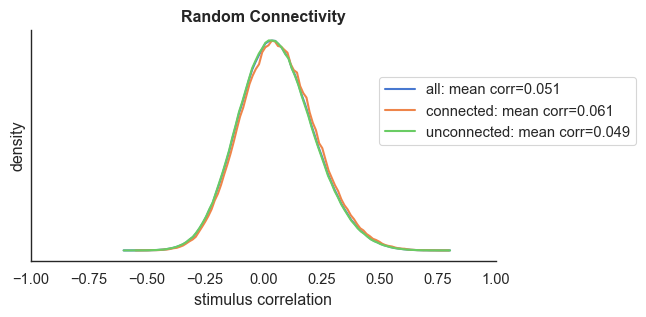

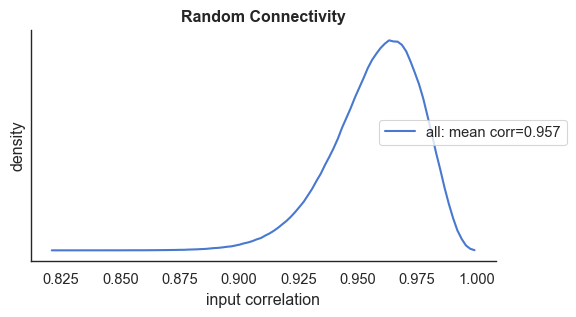

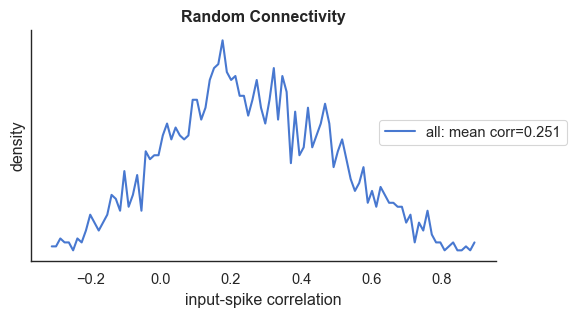

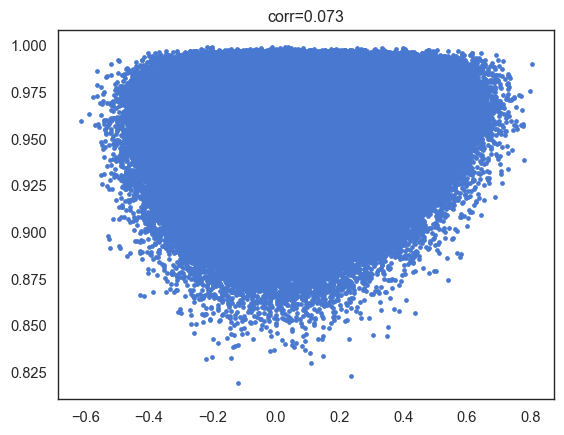

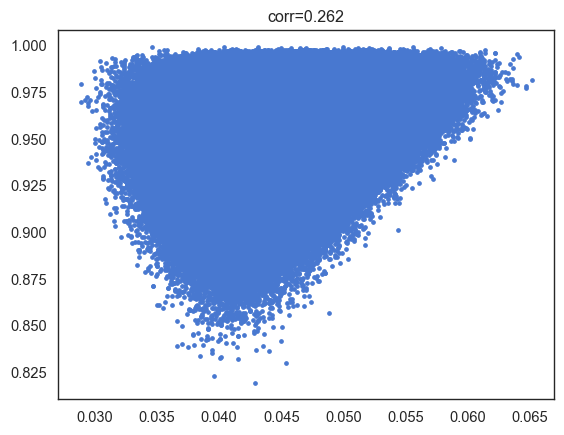

In [5]:
import seaborn as sns

sns.set(context='paper',style='white',font_scale=1.2,rc={"lines.linewidth":1.5})
sns.set_palette('muted')
#%config InlineBackend.figure_format = 'retina'

rmin=1.0/1000

nt=numtrials



# Counts from rates with burn-in and losing last bins bc of noise stuff
ECounts = dtRate*re[:nt,:,int(Tburn/dtRate)+1:int(-3*taustim/dtRate)-1]


# Average over trials
#ECounts = ECounts.mean(axis=0)
ECounts=ECounts[0,:,:]


ECutoffInds=np.where(ECounts.sum(axis=1)>T*rmin)[0]
numGood = len(ECutoffInds)
print(numGood,'of',Ne,'E neurons made the cut.')
#CutoffEECorrMatrix=np.corrcoef(ECounts[ECutoffInds])
Xcoarse = X.reshape((StimDim,-1,int(dtRate/dt))).mean(axis=2)
IEXcoarse = Jx[:Ne,:]@Xcoarse
IEXcoarse = IEXcoarse[:,int(Tburn/dtRate)+1:int(-3*taustim/dtRate)-1]
CutoffEXCorrMatrix = np.corrcoef(ECounts[ECutoffInds],IEXcoarse[ECutoffInds])

CutoffEECorrMatrix = CutoffEXCorrMatrix[:,:numGood][:numGood,:]
AllEECorrs = CutoffEECorrMatrix[np.triu_indices_from(CutoffEECorrMatrix,k=1)]

CutoffXXCorrMatrix = CutoffEXCorrMatrix[:,numGood:][numGood:,:]
AllXXCorrs = CutoffXXCorrMatrix[np.triu_indices_from(CutoffXXCorrMatrix,k=1)]

CutoffEXCorrMatrix = CutoffEXCorrMatrix[:,:numGood][numGood:,:]
# AllEXCorrs = CutoffEXCorrMatrix[np.triu_indices_from(CutoffEXCorrMatrix,k=0)]
AllEXCorrs = np.diag(CutoffEXCorrMatrix)

JxJxCutoff=(Jx[ECutoffInds,:]@Jx[ECutoffInds,:].T)
AllJxJx = JxJxCutoff[np.triu_indices_from(JxJxCutoff,k=1)]



Jee=J[:Ne,:Ne]
JeeCutoff=Jee[ECutoffInds,:][:,ECutoffInds]
ConnectedEECorrs=CutoffEECorrMatrix[np.where(np.triu(JeeCutoff,k=1))]
UnconnectedEECorrs=CutoffEECorrMatrix[np.where(np.triu(np.logical_not(JeeCutoff),k=1))]


print(nt)
print('Mean EE corr:',AllEECorrs.mean())
print('Std EE corr:',AllEECorrs.std())

print('Mean connected EE corr:',ConnectedEECorrs.mean())
print('Mean unconnected EE corr:',UnconnectedEECorrs.mean())




hAllEE,bAllEE=np.histogram(AllEECorrs,100,density=True)
hConnEE,bConnEE=np.histogram(ConnectedEECorrs,100,density=True)
hUnconnEE,bUnconnEE=np.histogram(UnconnectedEECorrs,100,density=True)

hAllXX,bAllXX=np.histogram(AllXXCorrs,100,density=True)
hAllEX,bAllEX=np.histogram(AllEXCorrs,100,density=True)

plt.figure(figsize=(6,3))
plt.plot(bAllEE[1:],hAllEE, label="all: mean corr={:.3f}".format(AllEECorrs.mean()))
plt.plot(bConnEE[1:],hConnEE, label="connected: mean corr={:.3f}".format(ConnectedEECorrs.mean()))
plt.plot(bUnconnEE[1:],hUnconnEE, label="unconnected: mean corr={:.3f}".format(UnconnectedEECorrs.mean()))
plt.ylabel('density')
plt.xlabel('stimulus correlation')
plt.legend(loc=(.75,.5))
plt.xlim([-1,1])
plt.title('Random Connectivity', weight='bold')
plt.yticks([])
sns.despine()

# Save figure if needed
SaveFigures=False
if SaveFigures:
    plt.savefig('./Figures/MultiTrialRandomConn.png')


plt.figure(figsize=(6,3))
plt.plot(bAllXX[1:],hAllXX, label="all: mean corr={:.3f}".format(AllXXCorrs.mean()))
plt.ylabel('density')
plt.xlabel('input correlation')
plt.legend(loc=(.75,.5))
#plt.xlim([-1,1])
plt.title('Random Connectivity', weight='bold')
plt.yticks([])
sns.despine()

plt.figure(figsize=(6,3))
plt.plot(bAllEX[1:],hAllEX, label="all: mean corr={:.3f}".format(AllEXCorrs.mean()))
plt.ylabel('density')
plt.xlabel('input-spike correlation')
plt.legend(loc=(.75,.5))
#plt.xlim([-1,1])
plt.title('Random Connectivity', weight='bold')
plt.yticks([])
sns.despine()

CorrEEXX = np.corrcoef(AllEECorrs,AllXXCorrs)[0,1]
plt.figure()
plt.plot(AllEECorrs,AllXXCorrs,'.')
plt.title("corr={:.3f}".format(CorrEEXX))


CorrJexXX = np.corrcoef(AllJxJx,AllXXCorrs)[0,1]
plt.figure()
plt.plot(AllJxJx,AllXXCorrs,'.')
plt.title("corr={:.3f}".format(CorrJexXX))

rSim = 7.449700000000002 18.4467 Hz


[]

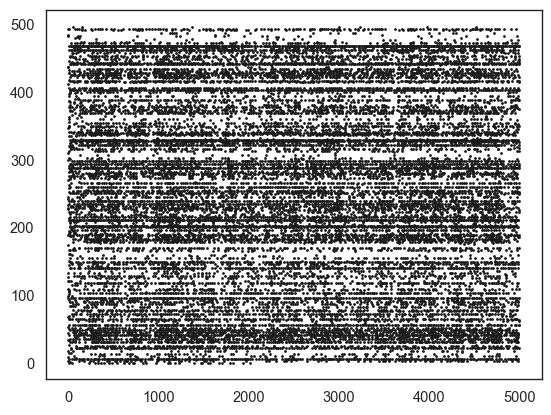

In [6]:

print('rSim =',1000*MeanERates,1000*MeanIRates,'Hz')


plt.figure()
NePlot=500
TPlot=5000
msize=2
Inds=np.where(np.logical_and(se[1,:]<NePlot , se[0,:]<=TPlot))
plt.plot(se[0,Inds],se[1,Inds]+1,'k.',markersize=msize)

# plt.figure()
# whichV=0
# Vplot=VeRec[time<=TPlot,whichV]
# PlotSpikeTimeInds = (se[0,se[1,:]==Ierecord[whichV]]/dt).astype(int)
# Vplot[PlotSpikeTimeInds]=0
# Vplot[Vplot>=0]=0

# plt.plot(time[time<=TPlot],Vplot)

[]

(5000, 10) (10, 200000) (5, 200000)


[]

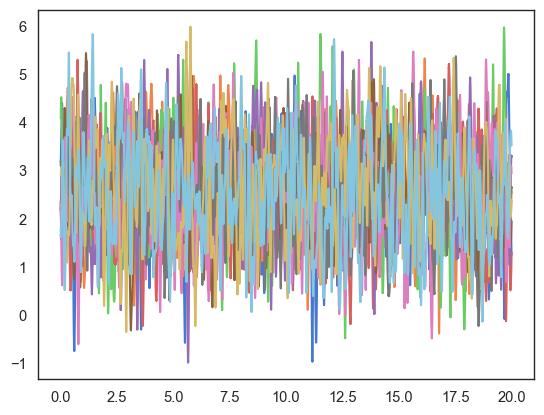

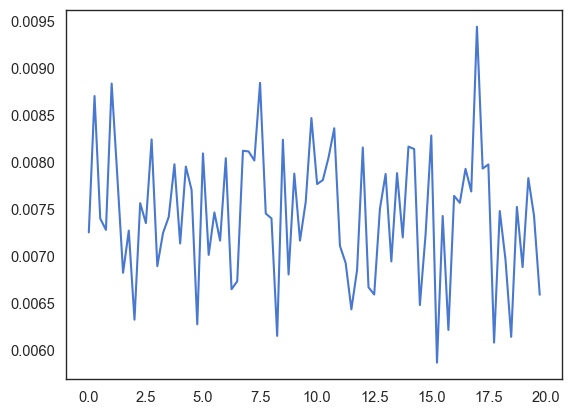

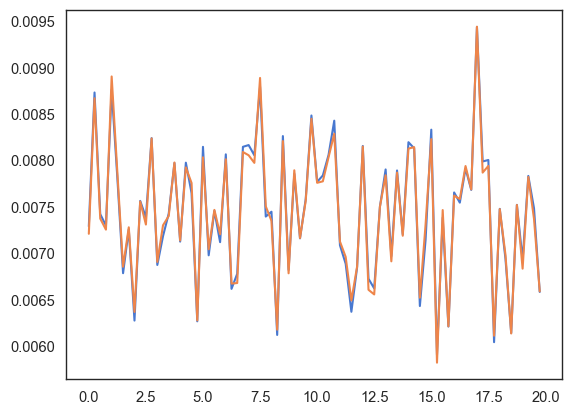

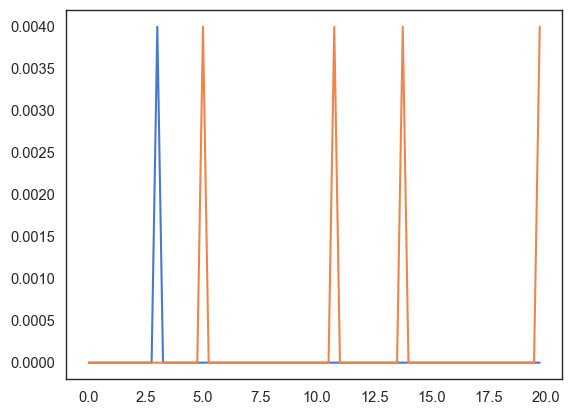

In [7]:
print(Jx.shape,X.shape,(Jx[:5,:]@X).shape)

cellnum=12

plt.figure()
plt.plot(time/1000,(X+X0[0]).T)
#plt.plot(RateTime/1000,re[:,cellnum,:].mean(axis=0)*dtRate)
#plt.plot(RateTime/1000,1000*re.mean(axis=(0,1)).T)

[]

plt.figure()
plt.plot(RateTime/1000,re.mean(axis=(0,1)).T)

plt.figure()
plt.plot(RateTime/1000,re.mean(axis=(1)).T)


plt.figure()
plt.plot(RateTime/1000,re[:,cellnum,:].T)
[]